## overview

In [1]:
# default package
import logging
import sys 
import os
import pathlib
import IPython
import random
from urllib.request import urlretrieve
import dataclasses as dc
import tempfile

In [2]:
# third party package
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import seaborn as sns
import yaml
from mlflow.tracking import MlflowClient
from matplotlib.font_manager import FontProperties
import matplotlib
import sklearn.preprocessing as preprocessing
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [3]:
# my package
sys.path.append(os.path.join(pathlib.Path().resolve(),"../"))
import src.model.network as network
import src.model.train as train
import src.dataset.time_dataset as time_dataset

In [4]:
# reload settings
%load_ext autoreload
%autoreload 2

In [5]:
# logger
logger=logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [6]:
# graph setting
sns.set()
font_path = "/usr/share/fonts/truetype/migmix/migmix-1p-regular.ttf"
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams["font.family"] = font_prop.get_name()

In [7]:
# gpu
torch.cuda.is_available()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# chdir
current_dir=pathlib.Path().resolve()
if current_dir.stem=="notebooks":
    os.chdir(current_dir.parent)
logger.info(pathlib.Path().resolve())

INFO:__main__:/workspaces/load_to_goal/GitHub/pytorch-implementation/time_series_forecasting


## load data&model

In [9]:
# mlflow global parameter
experiment_name="model01"
run_id="70e2c35c428d4892bdf25778473b5dd8"
tracking_uri="logs/mlruns"

In [10]:
def load_data_model():
    client = MlflowClient(tracking_uri=tracking_uri)
    with tempfile.TemporaryDirectory() as dname:
        config_path=client.download_artifacts(run_id,"config.yaml",dname)
        with open(config_path) as f:
            config=yaml.load(f,Loader=yaml.SafeLoader)
            
        # data
        df_train=pd.read_csv(config["data_path"]).iloc[:,1:]
        df_train=df_train[5::6]
        val_length=int(len(df_train)*config["val_ratio"])
        array_val=df_train.iloc[-val_length:].values
        array_train=df_train.iloc[:-val_length].values
        scaler = preprocessing.StandardScaler().fit(array_train)
        array_train = scaler.transform(array_train)
        array_val = scaler.transform(array_val) 
        
        # model
        model_path=[artifact.path for artifact 
                    in client.list_artifacts(run_id)
                    if "pth" in artifact.path][0]
        model_path=client.download_artifacts(run_id,model_path,dname)
        net=network.LSTM(
            input_size=array_train.shape[1],
            hidden_size=config["hidden_size"],
            output_size=array_train.shape[1]*config["label_length"],
        )
        model = train.TimeSeriesForecast(
            model=net,
            **config,
        )
        model.load_state_dict(torch.load(model_path))
        model=model.to(device)
        model.eval()
        
    return array_train,model

In [11]:
array_train,model=load_data_model()

In [12]:
td=time_dataset.TimeDataset(array_train,24,24)

In [13]:
input=td[0][0].unsqueeze(0).to(device)
label=td[0][1].numpy()

In [14]:
output=model(input).view(input.shape).to("cpu").detach().numpy()

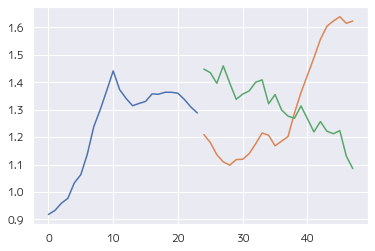

In [15]:
plt.plot(list(range(24)),input.to("cpu").detach().numpy()[0,:,0])
plt.plot(list(range(24,48)),label[:,0])
plt.plot(list(range(24,48)),output[0,:,0])